In [1]:
#Setting up Gerrychain to import the graph.
from gerrychain import Graph

In [2]:
#Setting up the file path to read 'ID_county.json' from the folder 'districting-data'.
filepath = 'districting-data/'
filename = 'ID_county.json'

#Gerrychains code for creating a graph from the file.
G = Graph.from_json( filepath + filename )

for node in G.nodes:
    #The population of each county.
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']
    #The longitudinal center of each county.
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20']
    #The latitudinal center of each county.
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20']

In [3]:
from geopy.distance import geodesic

#Creating a distance dictionary.
dist = { (i,j) : 0 for i in G.nodes for j in G.nodes }
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'], G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'], G.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles

In [27]:
#Imposing a 0.1% population deviation (+/-0.0005%)
deviation = 0.001

import math
#k is the number of districts j, selected for the model.
k = 2
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 919094 and U = 920012 and k = 2


In [28]:
#Importing Gurobipy and importing GRB from Gurobipy.
import gurobipy as gp
from gurobipy import GRB

#Creating the model. 
m = gp.Model()
#Create a variable x[i,j] which equals one when county i is assigned to the district centered at county j.
x = m.addVars( G.nodes, G.nodes, vtype=GRB.BINARY )

In [29]:
#The objective is to minimize the moment of inertia: sum (d^2 * p * x over all i and j).
m.setObjective( gp.quicksum( dist[i,j] * dist[i,j] * G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE )

In [30]:
#Adding constraints saying that each county i is assigned to one district.
m.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes )

#Adding constraint saying there should be k district centers.
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

#Adding constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U * x[j,j] for j in G.nodes )

#Adding coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

#Updating the model.
m.update()

In [31]:
#Adding contiguity constraints.
import networkx as nx
DG = nx.DiGraph(G)

#Adding the flow variables f[i,j,v] = flow across arc (i,j) that is sent from souce/root v.
f = m.addVars( DG.edges, G.nodes ) 

#Adding constraints saying that if node i is assigned to node j, then node i must consume one unit of node j's flow.
m.addConstrs( gp.quicksum( f[u,i,j] - f[i,u,j] for u in G.neighbors(i) ) == x[i,j] for i in G.nodes for j in G.nodes if i != j )

#Adding constraints saying that node i can receive flow of type j only if node i is assigned to node j.
M = G.number_of_nodes() - 1
m.addConstrs( gp.quicksum( f[u,i,j] for u in G.neighbors(i) ) <= M * x[i,j] for i in G.nodes for j in G.nodes if i != j )

#Adding constraints saying that node j cannot receive flow of its own type.
m.addConstrs( gp.quicksum( f[u,j,j] for u in G.neighbors(j) ) == 0 for j in G.nodes )

#Updating the model.
m.update()

In [32]:
#Solve, making sure to set a 0.00% MIP gap tolerance.
m.Params.MIPGap = 0.0

#Optimizing the model.
m.optimize()

Set parameter MIPGap to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-7267U CPU @ 3.10GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 5897 rows, 10912 columns and 39940 nonzeros
Model fingerprint: 0xb7c7f705
Variable types: 8976 continuous, 1936 integer (1936 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+05]
  Objective range  [9e+05, 7e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 174 rows and 289 columns
Presolve time: 0.20s
Presolved: 5723 rows, 10623 columns, 39232 nonzeros
Variable types: 8687 continuous, 1936 integer (1936 binary)

Root relaxation: objective 2.608242e+10, 1160 iterations, 0.12 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl 

In [33]:
#Print the objective value.
print(m.objVal)

#Retrieve the districts and their populations but first get the district "centers".
centers = [ j for j in G.nodes if x[j,j].x > 0.5 ]

districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in centers ]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

#Print district info.
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

28424150955.711872
District 0 has population 919165 and contains counties ['Cassia', 'Oneida', 'Payette', 'Fremont', 'Bannock', 'Twin Falls', 'Owyhee', 'Gooding', 'Caribou', 'Bear Lake', 'Lincoln', 'Camas', 'Canyon', 'Jefferson', 'Franklin', 'Madison', 'Clark', 'Jerome', 'Custer', 'Bonneville', 'Teton', 'Power', 'Blaine', 'Elmore', 'Butte', 'Minidoka', 'Bingham']

District 1 has population 919941 and contains counties ['Lemhi', 'Ada', 'Clearwater', 'Boise', 'Shoshone', 'Lewis', 'Washington', 'Latah', 'Boundary', 'Kootenai', 'Gem', 'Idaho', 'Benewah', 'Nez Perce', 'Adams', 'Valley', 'Bonner']



In [34]:
#Drawing the model as a map using Gurobi.
import geopandas as gpd

In [35]:
#Read the Idaho county shapefile from "ID_county.shp".
filepath = 'districting-data/'
filename = 'ID_county.shp'

#Read geopandas dataframe from file.
df = gpd.read_file( filepath + filename )

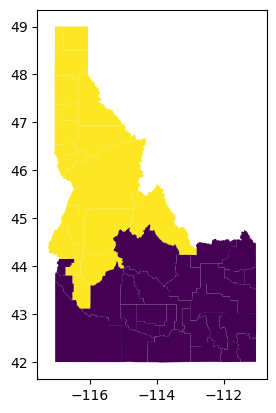

In [36]:
#Assigning each county i to district j.
assignment = [ -1 for i in G.nodes ]

labeling = { i : -1 for i in G.nodes }
for j in range(k):
    district = districts[j]
    for i in district:
        labeling[i] = j

#Adding the assignments to a column of the dataframe and mapping it.
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

#Pick a position u in the dataframe.
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    #Determining what node in the geoid.
    i = node_with_this_geoid[geoid]
    
    #The position u in the dataframe should be given the same district # that county i has in 'labeling'.
    assignment[u] = labeling[i]
    
#Adding the assignments to a column of our dataframe and then mapping it.
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()